In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import arviz as az
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()

from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
np.random.seed(44)


# Bayesian T-Test

Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``

# Reference for Bayesian t-test


> Kruschke J, **Doing Bayesian Data Analysis**, Ch. 12

# Drug trial evaluation

* We  want to  evaluate  of a drug that is supposed to increase intelligence.

* We have IQ measures  of:
    * 47 individuals receiving the drug  (treatment group)
    * 42 individuals  receiving the placebo (control group). 
    
* Some observations are however far from the mean.

In [4]:
drug = np.array ([101,100,102,104,105,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,104,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,103,103,100,101,103,104,100,101])
placebo = np.array ([ 99,101,100,101,99,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,98,99])

y  = pd.DataFrame(dict(value=np.r_[drug, placebo], group=np.r_[['drug']*len(drug), ['placebo']*len(placebo)]))

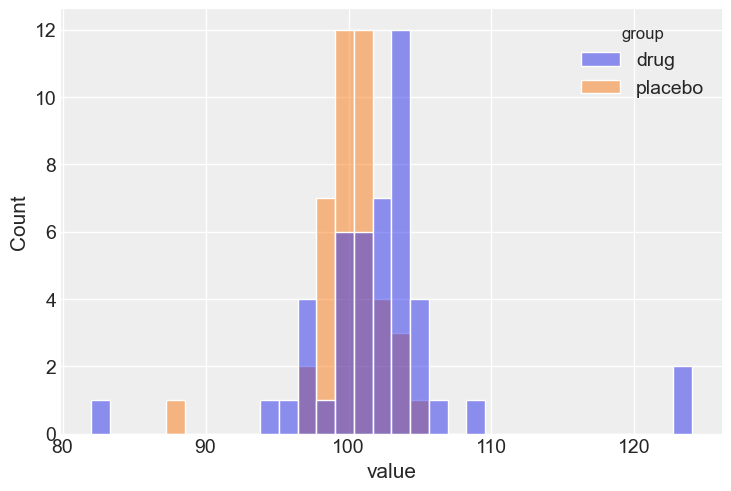

In [5]:
sns.histplot(data=y, x="value", hue="group");

# Research question
* The sample mean of Group 1 is superior, but there is a lot of variability within groups, and the variances of the two groups also appear to differ.
* There also appear to be some outliers.
* Are these groups credibly different?
* Is the drug credibly associated to a higher  IQ? 

## Likelihood

* We  assume the two populations to have their own means ($\mu_1, \mu_2$) and standard deviations ($\sigma_1, \sigma_2$).

* Given such parameters, and assuming a normal  likelihood function,  we have:

$$y^{(treat)}_i \sim N(\mu_1, \sigma_1)$$

$$y^{(placebo)}_i \sim N(\mu_2, \sigma_2)$$

where $i$ refers to the $i$-th individual in the group.

* To make inference on the $\mu$'s and on the $\sigma$'s, we need assigning priors to them.

# Prior on the mean of each group

* We assign a normal prior to both means.
* As mean of the prior, we use the mean of the  data, merging observations from the two groups (pooled mean).
* As standard deviation, we use twice the mean of the standard deviation of the two groups (pooled standard deviation). 

In [7]:
# 'pooled'  implies that we merge measures from both groups.
pooled_m = y.value.mean()
pooled_s = ( ( drug.std() + placebo.std()) /2)  * 2

with pm.Model():
    #the means of both groups have the same prior
    mu_drug        = pm.Normal ('mu_drug',     mu = pooled_m,  sd = pooled_s)
    mu_placebo  = pm.Normal ('mu_placebo', mu = pooled_m,  sd = pooled_s)

## Prior on standard deviation

* We give to  standard deviations  a uniform prior over a plausible range of values.

* Let us denote by $s_{p}$ the pooled standard deviation of the data.

* Kruschke's original model adopts the very wide range ($s_{p}/1000$, $s_{p} \cdot 1000$). But this gives a lot of prior weight to  inadmissable values.

## Prior on standard deviation

* In general it is better to apply any prior information that you have available. 

* The IQ can be interpreted according to the <a href="https://www.123test.com/interpretation-of-an-iq-score/"> IQ scale meaning </a>.

    * its  mean is about 100;  its standard devation in the whole population is  around 10 and the IQ is assumed to be normally distributed. 

    * thus extreme values of IQ  are 70 ( $\mu - 3 \sigma$: cognitively impaired) and 130 ($\mu + 3 \sigma$: very gifted). 


* We will thus adopt a Uniform(1,20) prior, thus applying widely diffuse information, but avoiding unadmissable order of magnitude. 
* **USARE LA HALF NORMAL??**

In [24]:
#full model

with pm.Model() as  diff_drug_model:
    mu_drug              = pm.Normal ('mu_drug',     mu = pooled_m,  sd = pooled_s)
    mu_placebo         = pm.Normal ('mu_placebo', mu = pooled_m,  sd = pooled_s)
    sigma_drug          =   pm.HalfNormal ('sigma_drug',       sigma=pooled_s*5)
    sigma_placebo     =   pm.HalfNormal ('sigma_placebo', sigma=pooled_s*5)

    
    #likelihood for the two groups
    y_drug      =  pm.Normal   ('y_1',  mu=mu_drug,    sigma=sigma_drug,    observed= drug)
    y_placebo = pm.Normal   ('y_2',  mu=mu_placebo, sigma=sigma_placebo, observed= placebo)

# Posterior distribution of some indicators

As indicators we consider:
* the difference between the means of the populations:
$$\mu_1 - \mu_2$$ 

*  Cohen's d (*effect size*, more about it later): 
$$
\displaystyle
\frac{\mu_2 - \mu_1}{\sqrt{\frac{\sigma_2^2 + \sigma_1^2}{2}}}
$$

This is the difference in means scaled by the pooled estimates of standard deviation.


* We  can define such indicators  as *deterministic* variables in PyMC3;  their sampled values will be part of the output.
* We can thus have their posterior distribution.

# Cohen's d (effect size)

$$
\frac{\mu_2 - \mu_1}{\sqrt{\frac{\sigma_2^2 + \sigma_1^2}{2}}}
$$

* It can be interpreted as a Z-score: the number of standard deviations that a value differs from the mean.
*  **Spiegare che il denominatore e' la varianza di x1 - x2 **
* It can be positive or negative depending on whether the difference is due to excess or deficiency. 
* A Cohen's d of -1.2 indicates that the mean of one group is 1.2 standard deviation below the mean of the other group.

# Interpretation of Cohen's d values

$$
\displaystyle
\frac{\mu_2 - \mu_1}{\sqrt{\frac{\sigma_2^2 + \sigma_1^2}{2}}}
$$

Guidelines:
* small  effect ($0 \leq d \leq 0.5$)
* medium effect  ($0.5 \leq d \leq 1$)
* large  effect ($d >  1$)

The same guidelines can be used to interpret negative values of  $d$.

In [25]:
with diff_drug_model:
    #The deterministic variables are function of the parameters, whose values appear in the trace.
    diff_of_means = pm.Deterministic ('diff_of_means', mu_drug - mu_placebo)
    effect_size         = pm.Deterministic('effect_size', diff_of_means / np.sqrt((sigma_drug**2 + sigma_placebo**2) / 2))
    trace                   = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_placebo, sigma_drug, mu_placebo, mu_drug]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


# Did the sampler converge? Trace plot of parameters and deterministic variables

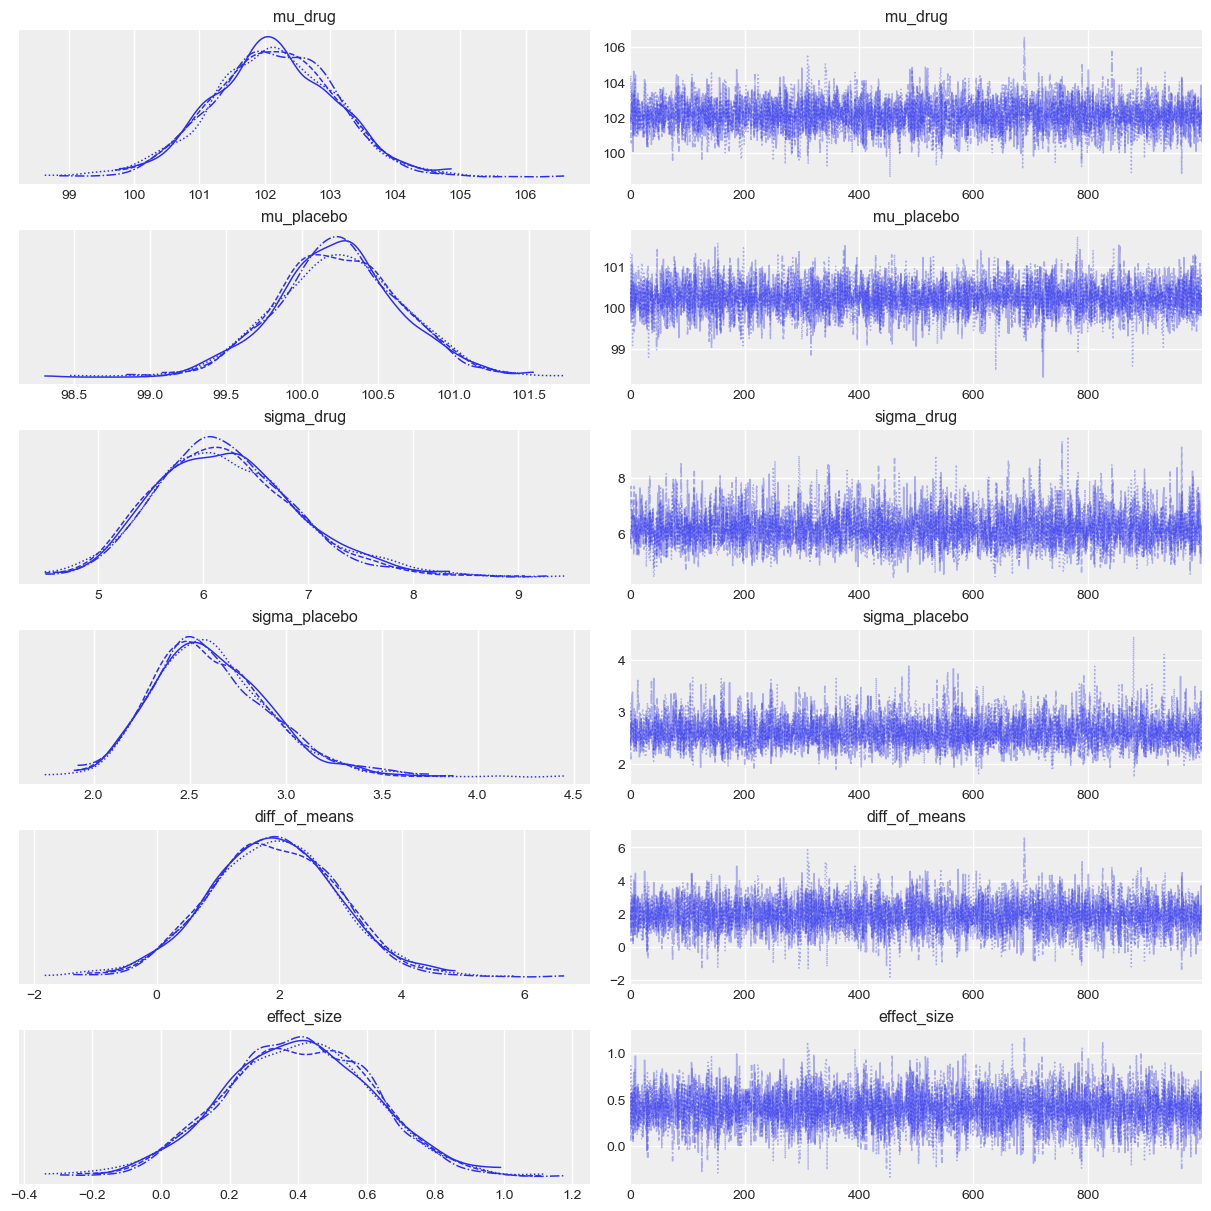

In [26]:
az.plot_trace(trace);

In [15]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_drug,102.150,0.918,100.380,103.835,0.012,0.009,5852.0,3036.0,1.0
mu_placebo,100.248,0.412,99.456,101.012,0.005,0.004,5782.0,3071.0,1.0
sigma_drug,6.207,0.673,5.027,7.488,0.010,0.007,4893.0,3029.0,1.0
sigma_placebo,2.618,0.301,2.087,3.166,0.004,0.003,4934.0,2796.0,1.0
diff_of_means,1.902,1.004,-0.141,3.672,0.013,0.010,5860.0,3051.0,1.0
effect_size,0.402,0.213,-0.029,0.777,0.003,0.002,5815.0,2874.0,1.0


# Is the model adequate? Posterior predictive checks

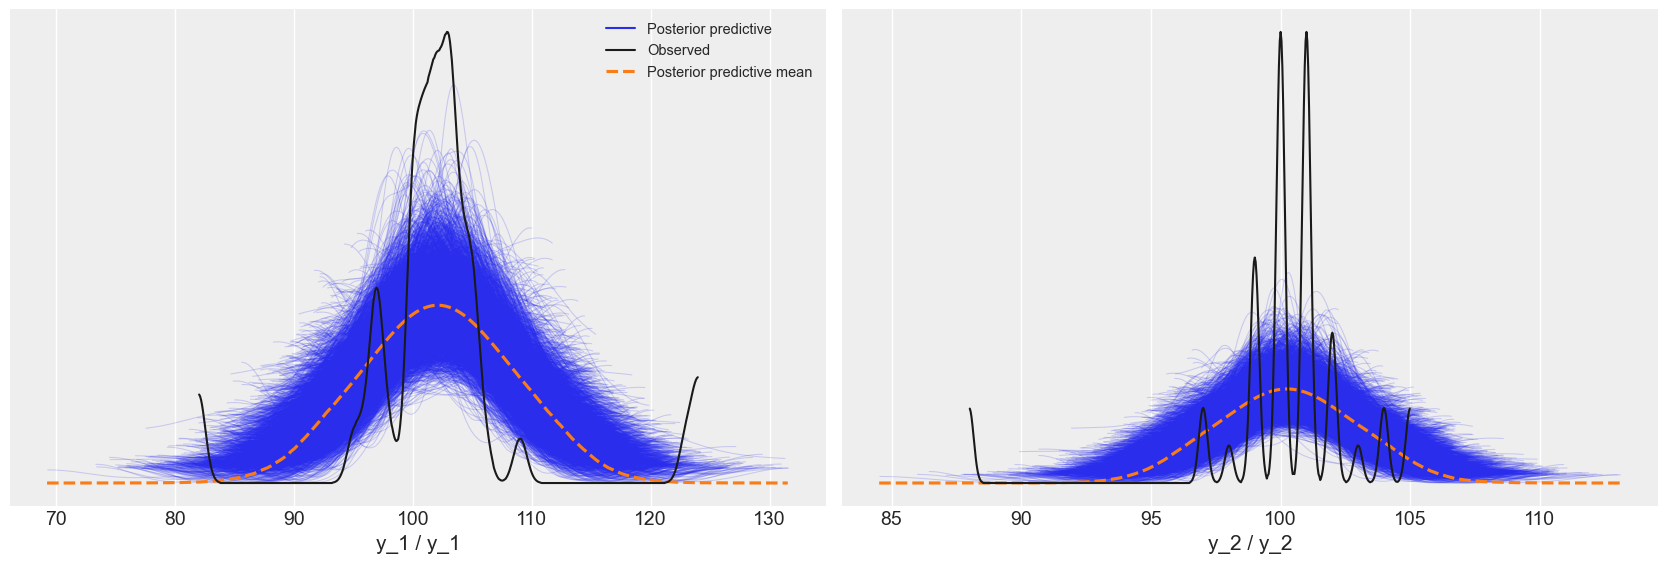

In [30]:
with diff_drug_model:
     ppc = pm.sample_posterior_predictive(trace)
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=diff_drug_model));

# Discussion
* The density is too low in the center of the distribution.
* For the moment, we continue the analysis with our current model.
* Later we will improve the model by making it robust.


# Assessing the credibility of the difference being 0
* We can assess the credibility of a certain value. 
* We are  interested in 0, which corresponds to the mean IQ being the same in the two groups. 
*  We thus  examine the posterior distribution of the credible parameter values and sees whether 0  falls in a region of high density or not.
* If the null value is far from the most credible values, we  reject it.

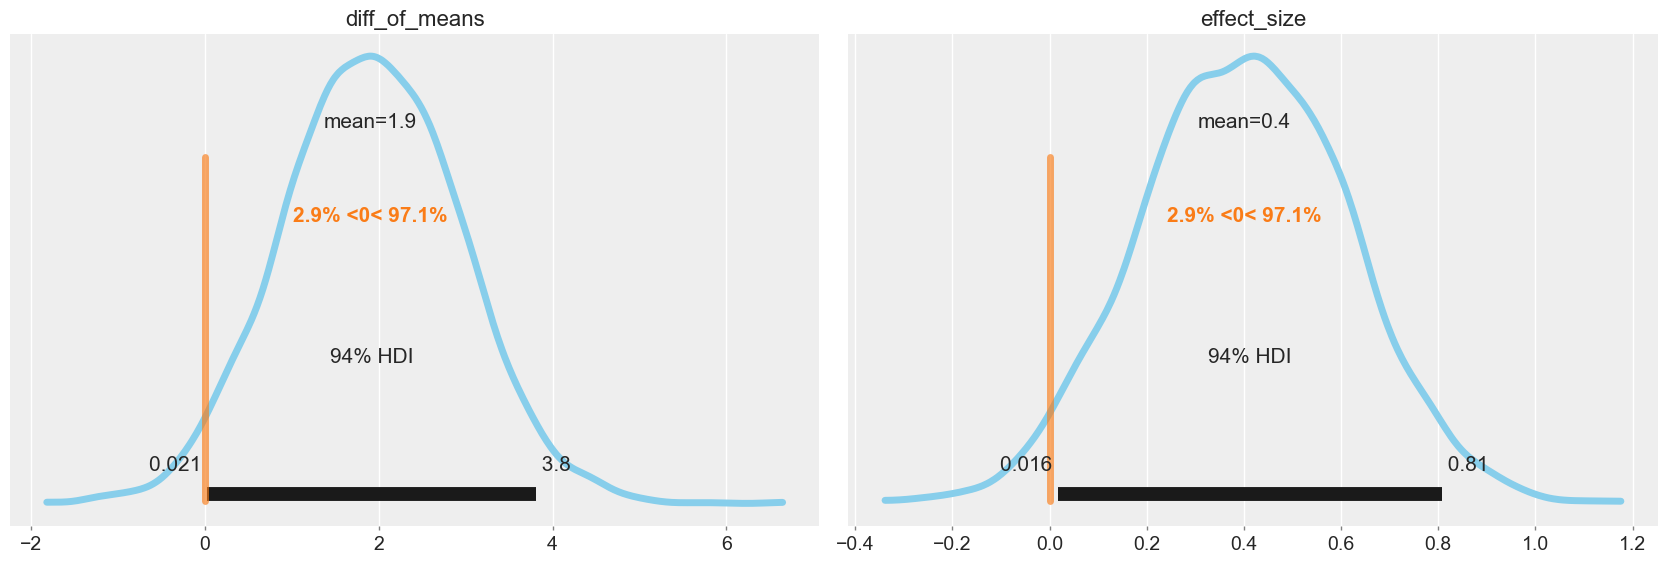

In [28]:
az.plot_posterior(trace, var_names=['diff_of_means','effect_size'],  ref_val=0, color='#87ceeb', linewidth=5);

# Fine-grained analysis of  the effect size

* The posterior probability of the effect size being small, medium, large are computed in the next slide.
* TO BE DONE


In [40]:
d             = az.extract_dataset(trace, var_names="effect_size")
p_small = 

In [45]:
d.cumulative_integrate?

# Discussion

* As the value of 0 is out of the 95 HDI, we can reject it: it is not plausible.
* The difference between the two means is 1.9 on average.
*  The 95% HDI of the difference of means falls well above zero, and about 97% of the credible values are greater than zero. 
* Thus the groups’ means are credibly different. 
* Bayesian analysis yields the posterior distribution of credible values, which we can use to take  conclusions


## Robust likelihood
We could choose  a Student-t distribution to describe the distributions of the scores in each group. This choice adds robustness to the analysis, as a T distribution is less sensitive to outlier observations, relative to a normal distribution.
As already discussed, we use a Student-t distribution with 4 degrees of freedom, in oder to filer outlieres.

Thus, the likelihood functions of our model are specified as follows:

$$y^{(treat)}_i \sim T(\nu=4, \mu_1, \sigma_1)$$

$$y^{(placebo)}_i \sim T(\nu=4, \mu_2, \sigma_2)$$


In [32]:
σ_low = 1
σ_high = 20
μ_m = y.value.mean()
μ_s = y.value.std() * 2

with pm.Model() as robust_model:
    #the first part of the model (prior on means and sigmas) does not change.
    mu_drug       = pm.Normal ('mu_drug',       mu=μ_m,  sd=μ_s)
    mu_placebo  = pm.Normal ('mu_placebo', mu=μ_m,  sd=μ_s)
    sigma_drug          =   pm.HalfNormal ('sigma_drug',       sigma=pooled_s*5)
    sigma_placebo     =   pm.HalfNormal ('sigma_placebo', sigma=pooled_s*5)

    #But we drop the normal likelihood
    #y_drug       = pm.Normal    ('y_1',  mu=mu_drug,      sigma=sigma_drug,      observed= drug)
    #y_placebo = pm.Normal   ('y_2',  mu=mu_placebo, sigma=sigma_placebo, observed= placebo)
    
    #Adopting instead a robust likelihood. 
    #For simplicity we use a Student T with nu=4.  A more sophisticated approach would be to put a prior also on nu, but
    #that makes the model more complex to sample. 
    group1 = pm.StudentT ('drug',       nu=4, mu=mu_drug,       sd=sigma_drug,       observed=drug)
    group2 = pm.StudentT ('placebo', nu=4, mu=mu_placebo,  sd=sigma_placebo, observed=placebo)
    
    #Derived quantities:
    diff_of_means = pm.Deterministic('diff_of_means', mu_drug - mu_placebo)
    effect_size         = pm.Deterministic('effect_size', diff_of_means / np.sqrt((sigma_drug**2 + sigma_placebo**2) / 2))
    robust_trace     = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_placebo, sigma_drug, mu_placebo, mu_drug]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [33]:
az.summary(robust_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_drug,101.831,0.500,100.847,102.737,0.007,0.005,5354.0,2953.0,1.0
mu_placebo,100.441,0.248,99.985,100.910,0.003,0.002,5593.0,3118.0,1.0
sigma_drug,3.001,0.479,2.147,3.880,0.007,0.005,5324.0,3025.0,1.0
sigma_placebo,1.412,0.235,0.990,1.866,0.003,0.002,6091.0,2575.0,1.0
diff_of_means,1.390,0.547,0.386,2.435,0.008,0.006,5288.0,3071.0,1.0
effect size,0.601,0.246,0.157,1.065,0.003,0.002,5526.0,3507.0,1.0


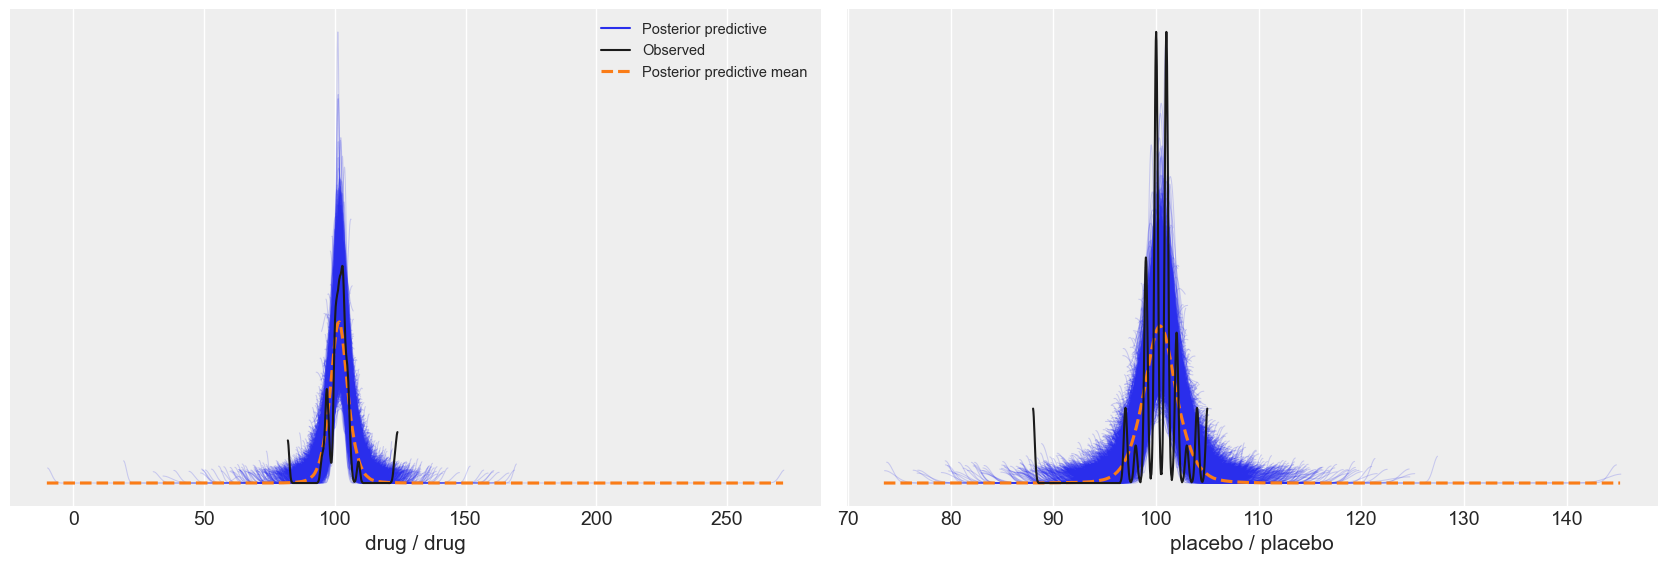

In [34]:
with robust_model:
     robust_ppc = pm.sample_posterior_predictive(robust_trace)
az.plot_ppc(az.from_pymc3(posterior_predictive=robust_ppc, model=robust_model));

# The robust model provides a better fit to the data. Which conclusions can we draw from the posterior?

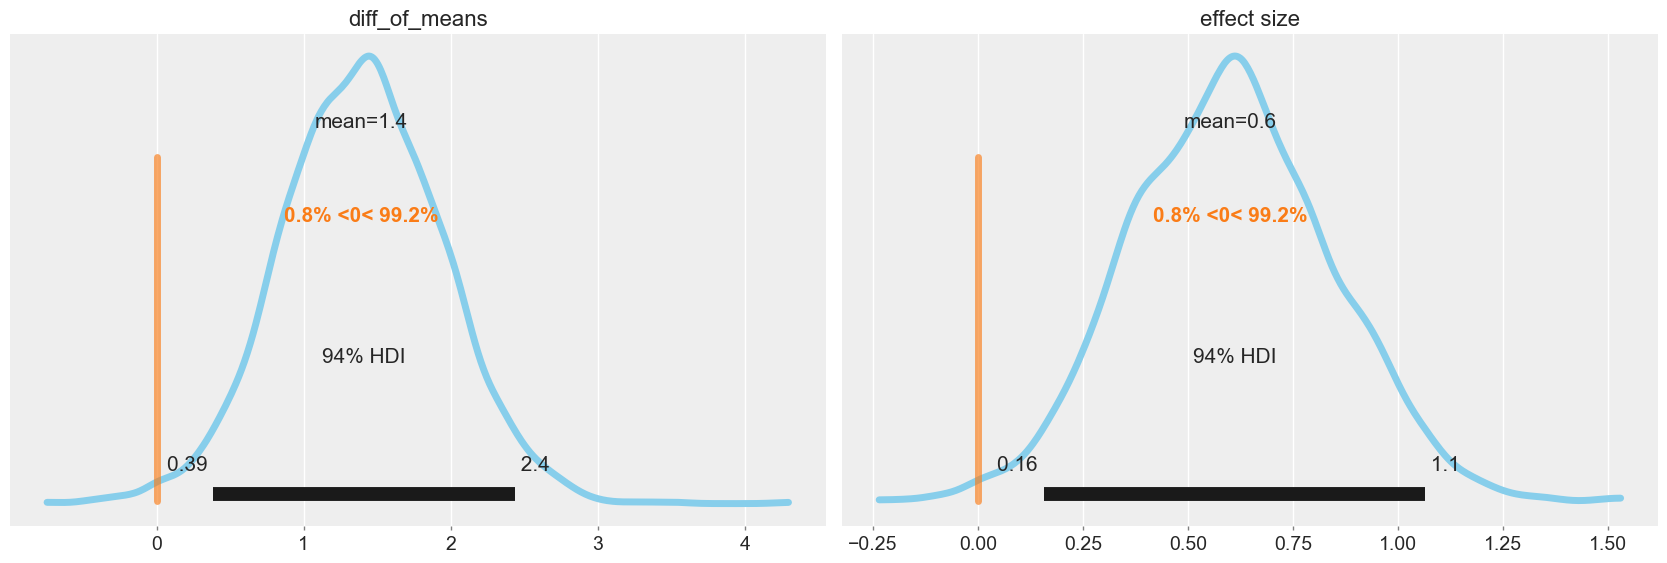

In [37]:
az.plot_posterior(robust_trace, var_names=[ 'diff_of_means', 'effect_size'], color='#87ceeb', linewidth=5, ref_val=0);

* The conclusions are even stronger than in the previous case, confirming the strong association between the drug and a highe IQ.

# aggiungere confronto con il t-test a due campiopni frequentista??